In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import sys
sys.path.append("..")

import jax
import jax.numpy as jnp
from jax import vmap, jit

import time
import matplotlib.pyplot as plt

In [2]:
from evosax.problems.pendulum import reset, step
from evosax.strategies.cma_es import init_strategy, ask, tell, check_termination
from evosax.utils import init_logger, update_logger, flat_to_mlp
from examples.ffw_pendulum import pendulum_rollout, init_policy_mlp

In [3]:
rng = jax.random.PRNGKey(0)

env_params = {"max_speed": 8,
              "max_torque": 2.,
              "dt": 0.05,
              "g": 10.0,
              "m": 1.,
              "l": 1.}

# Episode Rollout from Randomly Init Policy

In [4]:
# Rollout single episode with lax.scan
rng, rng_input = jax.random.split(rng)
policy_params = init_policy_mlp(rng_input, 1, [3, 16, 1], scale=1e-2)

rng, rng_input = jax.random.split(rng)
pendulum_rollout(rng_input, policy_params, env_params, num_steps=200)

DeviceArray(-600.16327, dtype=float32)

In [17]:
from evosax.utils import get_total_params
get_total_params(policy_params)

AttributeError: '_DeviceArray' object has no attribute 'keys'

## Vectorized Parallel Rollout of Eps with vmap

In [5]:
# Rollout a batch of parallel episodes using vmap
batch_rollout = jit(vmap(pendulum_rollout, in_axes=(0, None, None, None), out_axes=0),
                    static_argnums=(3))
rng, rng_input = jax.random.split(rng)
rollout_keys = jax.random.split(rng_input, 10)
batch_rollout(rollout_keys, policy_params, env_params, 200)

DeviceArray([ -626.7644 , -1068.5372 , -1775.2993 , -1148.9524 ,
              -863.488  ,  -710.9215 ,  -940.70044, -1348.843  ,
             -1785.6412 , -1167.9044 ], dtype=float32)

In [6]:
# Generate a batch of 5 weight initialisations
generation_params = init_policy_mlp(rng_input, 5, [3, 16, 1], scale=1e-2)

In [7]:
# Rollout 10 episodes for 5 agents in parallel
v_dict = {"W1": 0, "b1": 0, "W2": 0, "b2": 0}
generation_rollout = jit(vmap(batch_rollout, in_axes=(None, v_dict, None, None),
                              out_axes=0), static_argnums=(3))
results = generation_rollout(rollout_keys, generation_params, env_params, 200)
print(results.shape)

(5, 10)


In [8]:
# Sanity check on one of the 5
i = 1
policy_sub = {"W1": generation_params["W1"][i],
              "b1": generation_params["b1"][i],
              "W2": generation_params["W2"][i],
              "b2": generation_params["b2"][i]}
batch_rollout(rollout_keys, policy_sub, env_params, 200)

Buffer([ -686.62964, -1067.7192 , -1773.2312 , -1146.1252 ,  -863.0676 ,
         -747.98193,  -955.1147 , -1351.132  , -1787.5454 , -1167.5414 ],       dtype=float32)

# Neuroevolution with CMA-ES

In [9]:
network_shapes = [3, 48, 1]
num_params = 3*48 + 48 + 48*1 + 1
rng = jax.random.PRNGKey(0)
mean_init, sigma_init = jnp.zeros(num_params), 1
pop_size, mu = 100, 50
num_evals_per_gen = 20
num_generations = 200
num_env_steps = 200

top_k = 5
evo_logger = init_logger(top_k, num_params)

params, memory = init_strategy(mean_init, sigma_init,
                               pop_size, mu)

In [15]:
x.shape
network_shapes

[3, 48, 1]

# Run generation loop on Pendulum Task

In [10]:
start_t = time.time()
for g in range(num_generations):
    rng, rng_input = jax.random.split(rng)
    x, memory = ask(rng_input, params, memory)
    generation_params = flat_to_mlp(x, network_shapes)
    rng, rng_input = jax.random.split(rng)
    rollout_keys = jax.random.split(rng_input, num_evals_per_gen)

    population_returns = generation_rollout(rollout_keys, generation_params,
                                            env_params, num_env_steps)
    values = - population_returns.mean(axis=1)
    memory = tell(x, values, params, memory)
    evo_logger = update_logger(evo_logger, x, values, memory, top_k)
    if (g + 1) % 15 == 0:
        print("# Generations: {} | Fitness: {:.2f} | Cum. Time: {:.2f}".format(
                g+1, evo_logger["top_values"][0],
                time.time()-start_t))
        # jnp.save("gen_" + str(g+1), evo_logger["top_params"])
        if check_termination(values, params, memory):
            break

# Generations: 15 | Fitness: 824.89 | Cum. Time: 7.24
# Generations: 30 | Fitness: 483.24 | Cum. Time: 9.18
# Generations: 45 | Fitness: 252.67 | Cum. Time: 10.75
# Generations: 60 | Fitness: 220.07 | Cum. Time: 12.24
# Generations: 75 | Fitness: 167.79 | Cum. Time: 13.74
# Generations: 90 | Fitness: 144.67 | Cum. Time: 15.26
# Generations: 105 | Fitness: 113.75 | Cum. Time: 16.82
# Generations: 120 | Fitness: 113.75 | Cum. Time: 18.38
# Generations: 135 | Fitness: 113.75 | Cum. Time: 19.98
# Generations: 150 | Fitness: 113.75 | Cum. Time: 21.70
# Generations: 165 | Fitness: 113.75 | Cum. Time: 23.35
# Generations: 180 | Fitness: 113.75 | Cum. Time: 25.18
# Generations: 195 | Fitness: 102.14 | Cum. Time: 26.92


# Visualize log over generations

In [11]:
from evosax.visualize.plot_log import plot_fitness, plot_sigma
import matplotlib.pyplot as plt

(<Figure size 864x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe021e4a550>)

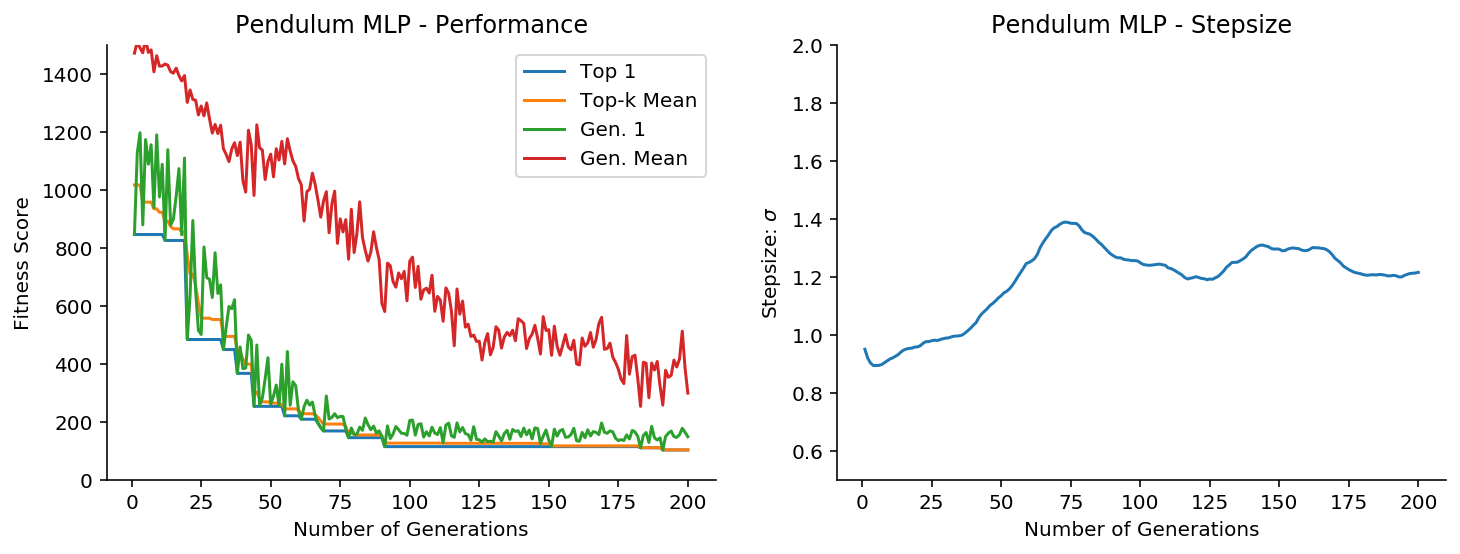

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plot_fitness(evo_logger, title="Pendulum MLP - Performance", ylims=(0, 1500), fig=fig, ax=axs[0])
plot_sigma(evo_logger, title="Pendulum MLP - Stepsize", ylims=(0.5, 2), fig=fig, ax=axs[1])